# Tansania Travel Spendings Predictions

## Importing libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [82]:
df_train = pd.read_csv('data/Train.csv')
df_test  = pd.read_csv('data/Test.csv')

## Overview of the dataset

There are 4809 rows and 23 columns in this dataset.

In [53]:
df_train.shape

(4809, 23)

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [56]:
df_train.describe().round().T

,count,mean,std,min,25%,50%,75%,max
total_female,4806.0,1.0,1.0,0.0,0.0,1.0,1.0,49.0
total_male,4804.0,1.0,1.0,0.0,1.0,1.0,1.0,44.0
night_mainland,4809.0,8.0,10.0,0.0,3.0,6.0,11.0,145.0
night_zanzibar,4809.0,2.0,4.0,0.0,0.0,0.0,4.0,61.0
total_cost,4809.0,8114389.0,12224903.0,49000.0,812175.0,3397875.0,9945000.0,99532875.0


## Check for duplicates

There are no duplicate rows in the dataset.

In [83]:
df_train.duplicated().sum()

0

## Basic logical cleanups

### Drop ID column

In [98]:
df_train.drop('ID', axis=1, inplace=True)

### Fix typographical error (leading whitespace) for all "Wildlife" entries

In [107]:
df_train.replace({" Wildlife": "Wildlife"}, inplace=True)

### Replace Yes/No with True/False

In [84]:
#df_train.replace({'Yes': True, 'No': False}, inplace=True)
# or better 1 and 0 ? that changes something
df_train.replace({'Yes': 1, 'No': 0}, inplace=True)

### Convert Currency to EUR

Tanzanian Schillings are quite big. Let's convert them to Euros to better a better picture of the spendings.

In [110]:
conversion_rate =  0.000365
df_train['total_cost_euro'] = round(df_train['total_cost'] * conversion_rate, 2)

In [111]:
df_train.total_cost_euro.describe()

count     4809.000000
mean      2961.751703
std       4462.089690
min         17.880000
25%        296.440000
50%       1240.220000
75%       3629.920000
max      36329.500000
Name: total_cost_euro, dtype: float64

We can see that the average spending is about 3000 Euros. 

### Fixing country names

In [148]:
country_replacements = {
    "SWIZERLAND": "SWITZERLAND",
    "BURGARIA":   "BULGARIA",
    "MALT":       "MALTA",
    "DRC":        "DEMOCRATIC REPUBLIC OF THE CONGO",
    "SCOTLAND":   "UNITED KINGDOM",
    "UAE":        "UNITED ARAB EMIRATES",
    "PHILIPINES": "PHILIPPINES",
    "DJIBOUT":    "DJIBOUTI",
    "MORROCO":    "MOROCCO"
}
df_train.country = df_train.country.replace(country_replacements)

### Convert Float columns to Integer

In [8]:
#columns_to_convert = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']
#df_train[columns_to_convert] = df_train[columns_to_convert].notna().astype(int)

In [192]:
# this somehow created problems with the calculations of travel_with data

## Missing Data

In [127]:
missing_fields = df_train.isna().sum()

print("Sum of all missing fields:", missing_fields.sum())
print(missing_fields)

Sum of all missing fields: 0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
total_cost_euro          0
single_female            0
single_male              0
number_travelers         0
night_total              0
dtype: int64


There are four columns with missing values:   
- `travel_with` has a very high number of missing values (1114).   
- `most_impressing` has 313 missing values.  
- The missing values for `total_female` and `total_male` are almost insignificant (3 and 5). 

After further investigation we figured that most of the missing `travel_with` values can be deducted by looking at the `total_female` and `total_male` columns. If `total_female` equals 1 and `total_male` equals 0, that means it's a single female traveler and the value for `travel_with` should be `Alone`. And vice versa for single male travelers.

### Deducting missing 'travel_with' values

In [88]:
no_women  = df_train['total_female'] == 0
one_woman = df_train['total_female'] == 1
no_men    = df_train['total_male']   == 0
one_man   = df_train['total_male']   == 1
singles   = (one_woman & no_men) | (no_women & one_man)

# set single travelers to 'Alone'
df_train.loc[singles, 'travel_with'] = 'Alone'

# create new columns for single travelers (OHE)
df_train['single_female']   = one_woman & no_men
df_train['single_male']     = no_women & one_man
#df_train['single_traveler'] = singles # that's probably unnecessary, because of later OHE
df_train["number_travelers"] = df_train["total_female"] + df_train["total_male"]

# the rest without travel_with field: 26 Rows
df_train[df_train.travel_with.isna()].head(2)

# check for those anomalies
#df_train.loc[no_women & no_men]
#df_train.loc[one_woman & one_man]


,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,total_cost_euro,single_female,single_male,number_travelers
638,tour_1785,UNITED KINGDOM,25-44,NaN,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,7.0,0.0,Cash,1,Friendly People,3149250.0,1149.48,False,False,2.0
681,tour_1837,UNITED STATES OF AMERICA,1-24,NaN,0.0,4.0,Leisure and Holidays,Conference tourism,"Radio, TV, Web",Package Tour,...,10.0,0.0,Cash,1,No comments,4309500.0,1572.97,False,False,4.0


### Let's just drop the entries with missing values

In [117]:
df_train.dropna(inplace=True)

In [122]:
df_train.isna().sum()

country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
total_cost_euro          0
single_female            0
single_male              0
number_travelers         0
night_total              0
dtype: int64

## Adding Features

In [126]:
# create a new feature 'night_total'
df_train['night_total'] = df_train['night_zanzibar'] + df_train['night_mainland']

## Nights spend on Mainland vs. Zanzibar

In [123]:
df_train[['night_zanzibar', 'night_mainland', 'night_total']].describe().round().T

,count,mean,std,min,25%,50%,75%,max
night_zanzibar,4465.0,2.0,4.0,0.0,0.0,0.0,4.0,61.0
night_mainland,4465.0,9.0,10.0,0.0,3.0,6.0,11.0,145.0
night_total,4465.0,11.0,11.0,0.0,4.0,8.0,14.0,145.0


People spend on average two nights on Zanzibar, while they stayed eight nights on the mainland.


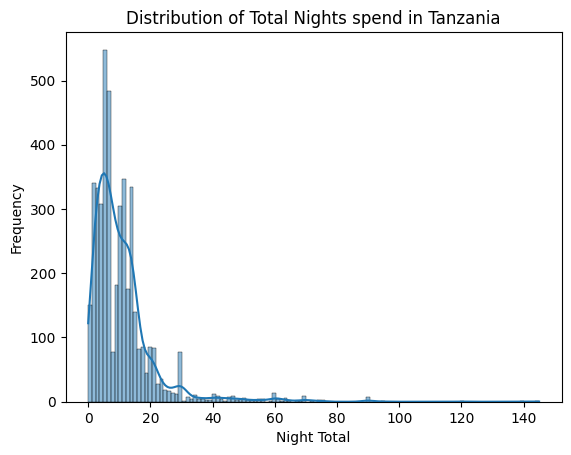

In [128]:
sns.histplot(df_train['night_total'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()

In [150]:
df_train.total_cost_euro.describe().round(2)

count     4465.00
mean      3070.11
std       4522.17
min         17.88
25%        302.49
50%       1337.02
75%       3690.42
max      36329.50
Name: total_cost_euro, dtype: float64

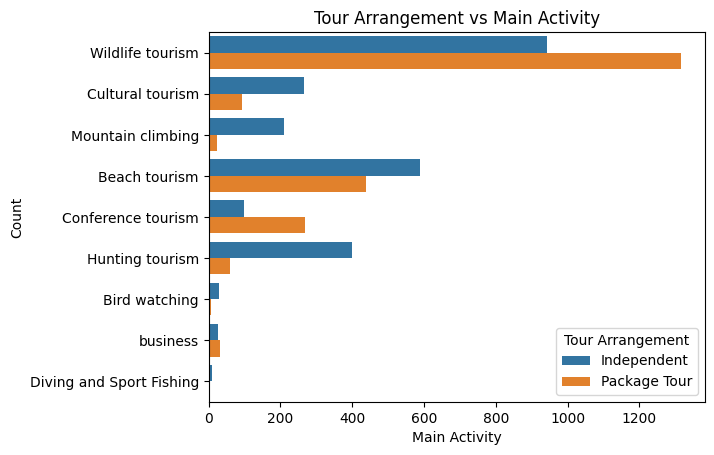

In [93]:
sns.countplot(y='main_activity', hue='tour_arrangement', data=df_train)
plt.title('Tour Arrangement vs Main Activity')
plt.xlabel('Main Activity')
plt.ylabel('Count')
plt.legend(title='Tour Arrangement')
plt.show()

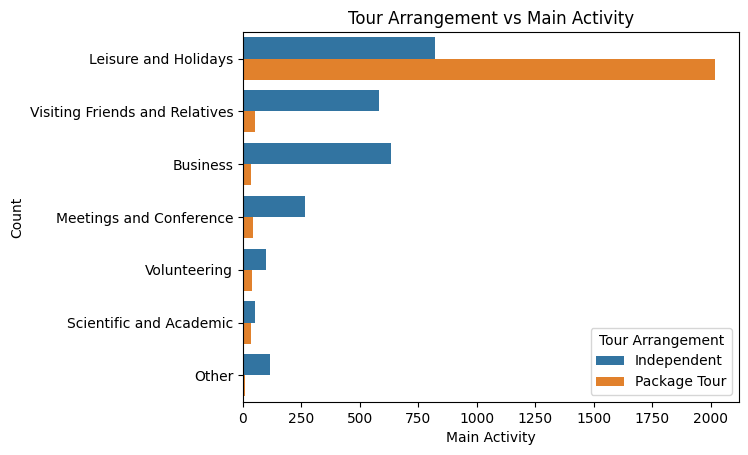

In [32]:
sns.countplot(y='purpose', hue='tour_arrangement', data=df_train)
plt.title('Tour Arrangement vs Main Activity')
plt.xlabel('Main Activity')
plt.ylabel('Count')
plt.legend(title='Tour Arrangement')
plt.show()

## Unique values of categorial columns

In [224]:
categories = ['most_impressing', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'payment_mode']

for cat in categories:
    print('-'*80)
    print(f"[Category: {cat}] - [Null: {df_train[cat].isna().sum()}]\n")
    print(df_train[cat].value_counts())

--------------------------------------------------------------------------------
[Category: most_impressing] - [Null: 0]

most_impressing
Friendly People                         1533
Wildlife                                1033
No comments                              737
Wonderful Country, Landscape, Nature     504
Good service                             361
Excellent Experience                     266
Satisfies and Hope Come Back              31
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: purpose] - [Null: 0]

purpose
Leisure and Holidays              2733
Visiting Friends and Relatives     571
Business                           561
Meetings and Conference            283
Volunteering                       133
Other                              101
Scientific and Academic             83
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: main_act

## Save cleaned dataset to file

In [151]:
df_train.to_csv('data/savegame.csv', index=False)

## Graphical Insides

### Correlations

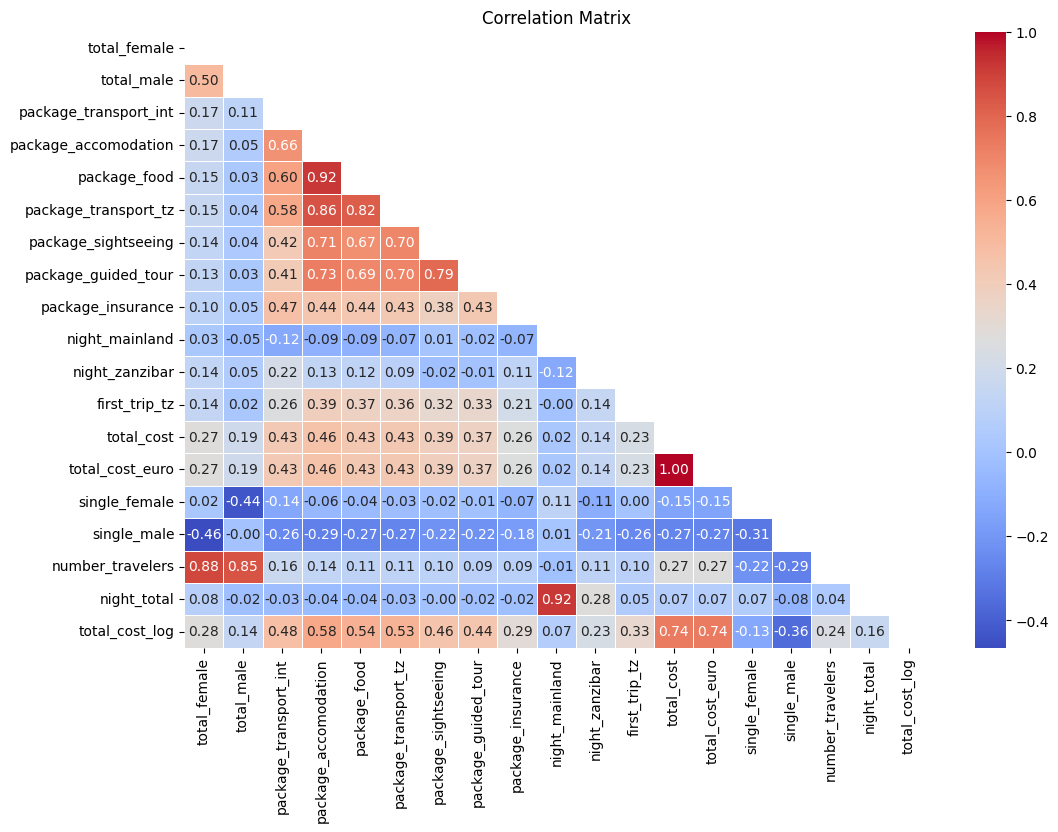

In [184]:
corr=df_train.corr(numeric_only=True)
mask=np.triu(corr)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Top Countries

#### Distribution

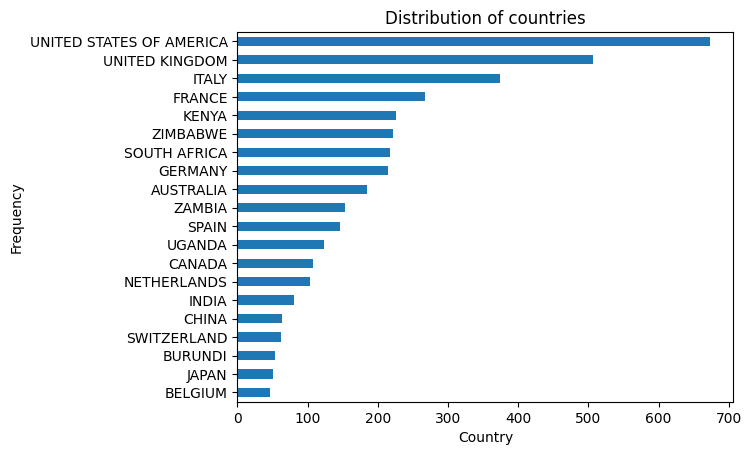

In [300]:
df_train['country'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title("Distribution of countries")
plt.xlabel("Country")
plt.ylabel("Frequency");


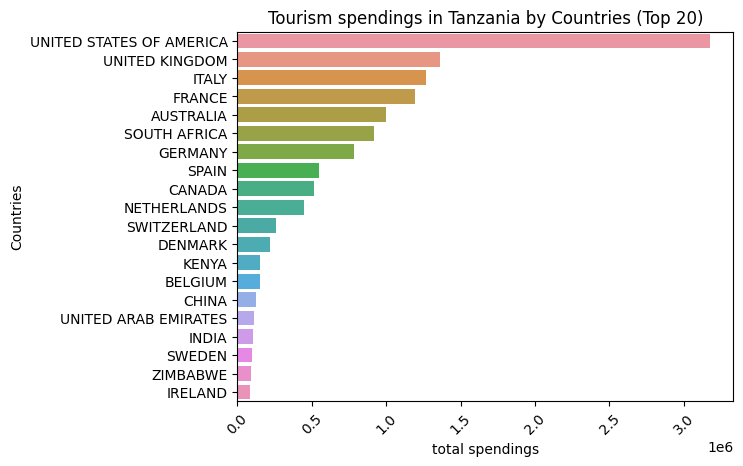

In [297]:
df_country = df_train.groupby(['country'])['total_cost_euro'].sum().rename("total_cost_by_country")
df_country= df_country.to_frame().reset_index()
df_country_sort= df_country.sort_values(['total_cost_by_country'],ascending=False).head(20)

sns.barplot(y='country', x='total_cost_by_country', data=df_country_sort)

plt.xticks(rotation=45)
plt.xlabel("total spendings")
plt.ylabel("Countries")
plt.title("Tourism spendings in Tanzania by Countries (Top 20)")
plt.show()


### Age Groups

#### Distribution

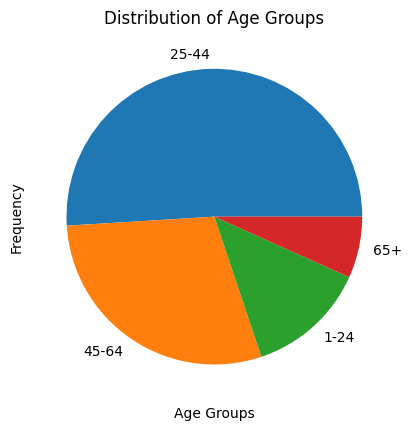

In [175]:
df_train['age_group'].value_counts().plot(kind='pie')
plt.title("Distribution of Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Frequency");

#### Spendings

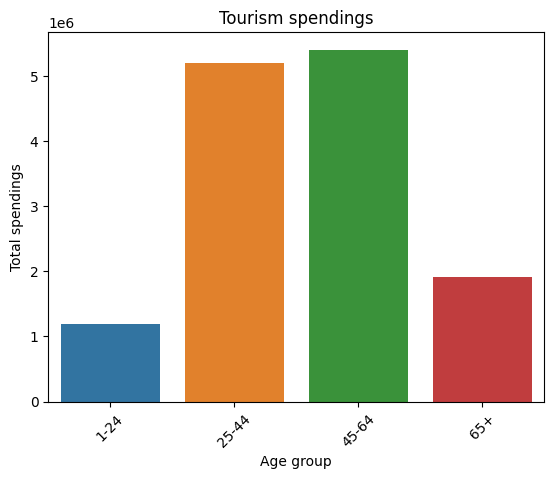

In [220]:
df_age= df_train.groupby(['age_group'])['total_cost_euro'].sum().rename("total_cost_by_age")
df_age= df_age.to_frame().reset_index()

sns.barplot(x='age_group', y='total_cost_by_age', data=df_age)

plt.xticks(rotation=45)
plt.ylabel("Total spendings")
plt.xlabel("Age group")
plt.title("Tourism spendings")
plt.show()

### People traveled with

#### Distribution

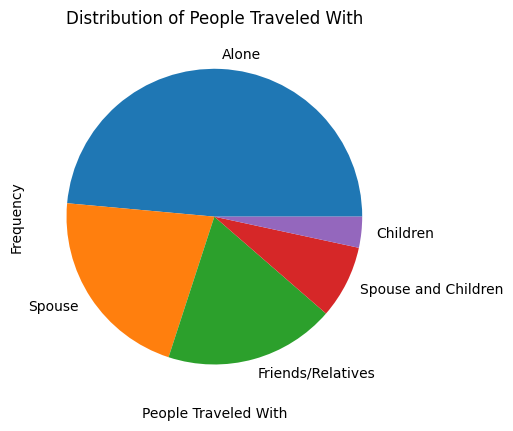

In [283]:
df_train['travel_with'].value_counts().plot(kind='pie') # bar, barh, 
plt.title("Distribution of People Traveled With")
plt.xlabel("People Traveled With")
plt.ylabel("Frequency");

#### Spendings

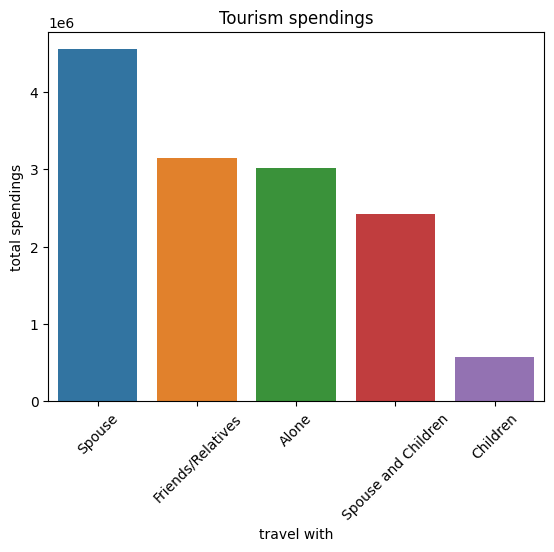

In [262]:
df_country = df_train.groupby(['travel_with'])['total_cost_euro'].sum().rename("travel_cost_by_travel_with").sort_values(ascending=False)
df_country= df_country.to_frame().reset_index()

sns.barplot(x='travel_with', y='travel_cost_by_travel_with', data=df_country)

plt.xticks(rotation=45)
plt.ylabel("total spendings")
plt.xlabel("travel with")
plt.title("Tourism spendings")
plt.show()

### Distribution of Information Sources

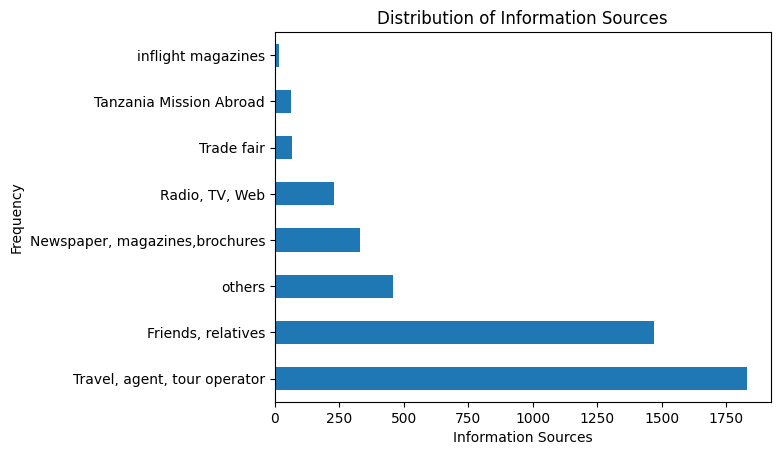

In [281]:
df_train['info_source'].value_counts().plot(kind='barh')
plt.title("Distribution of Information Sources")
plt.xlabel("Information Sources")
plt.ylabel("Frequency");

### Impressions

#### Distribution

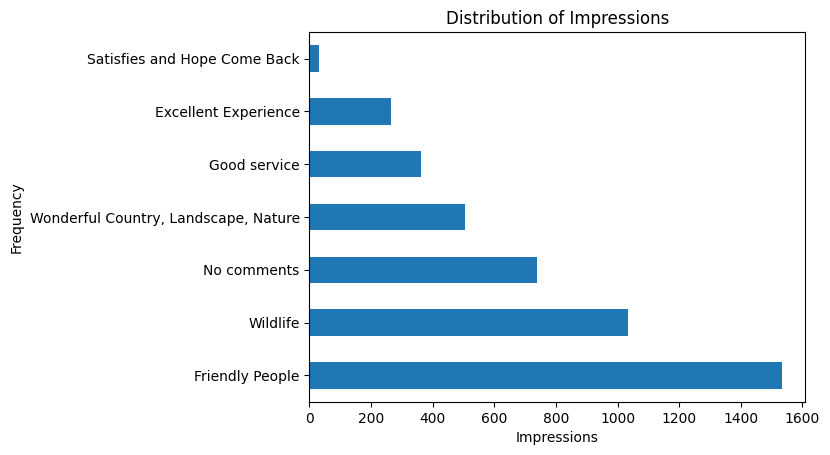

In [251]:
df_train['most_impressing'].value_counts().plot(kind='barh')
plt.title("Distribution of Impressions")
plt.xlabel("Impressions")
plt.ylabel("Frequency");

#### Spendings

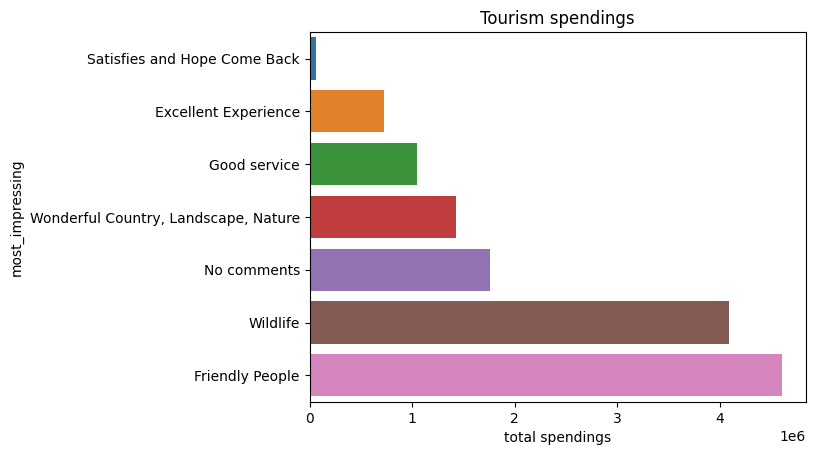

In [280]:
df_activity = df_train.groupby(['most_impressing'])['total_cost_euro'].sum().rename("travel_cost_by_most_impressing").sort_values()
df_activity= df_activity.to_frame().reset_index()

sns.barplot(y='most_impressing', x='travel_cost_by_most_impressing', data=df_activity)

plt.xlabel("total spendings")
plt.ylabel("most_impressing")
plt.title("Tourism spendings")
plt.show()

### Main activities

#### Distribution

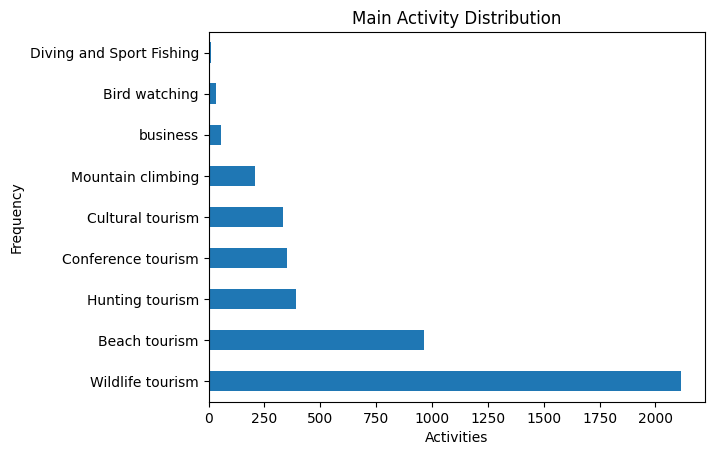

In [267]:
df_train['main_activity'].value_counts().plot(kind='barh')
plt.title("Main Activity Distribution")
plt.xlabel("Activities")
plt.ylabel("Frequency");

#### Spendings

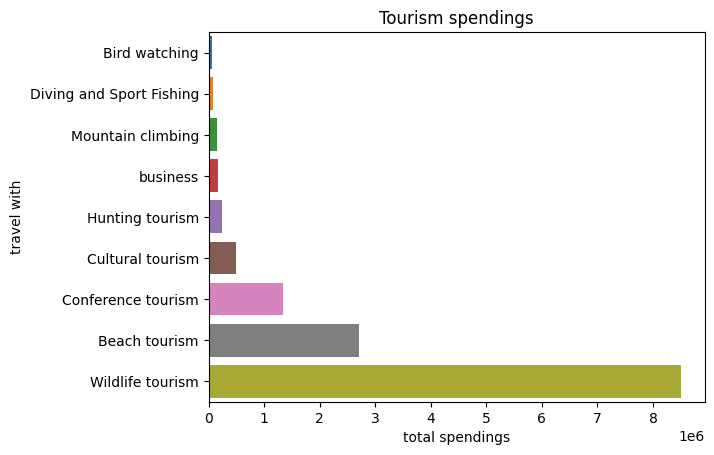

In [268]:
df_activity = df_train.groupby(['main_activity'])['total_cost_euro'].sum().rename("travel_cost_by_main_activity").sort_values()
df_activity= df_activity.to_frame().reset_index()

sns.barplot(y='main_activity', x='travel_cost_by_main_activity', data=df_activity)

plt.xlabel("total spendings")
plt.ylabel("travel with")
plt.title("Tourism spendings")
plt.show()

### Purpose of travel

#### Distribution

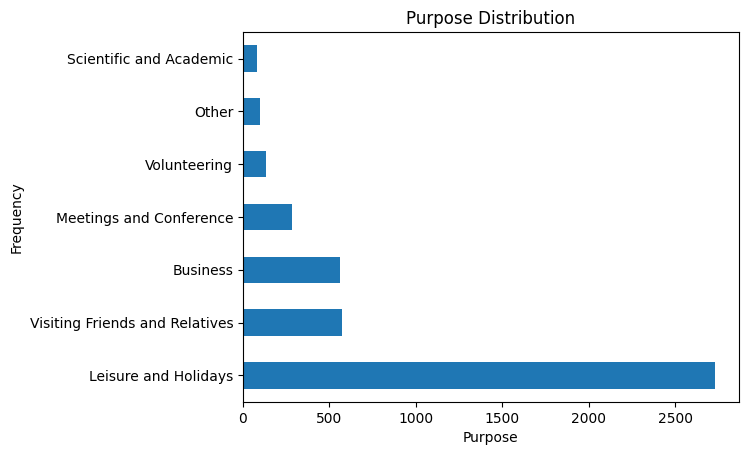

In [277]:
df_train['purpose'].value_counts().plot(kind='barh')
plt.title("Purpose Distribution")
plt.xlabel("Purpose")
plt.ylabel("Frequency");

#### Spendings

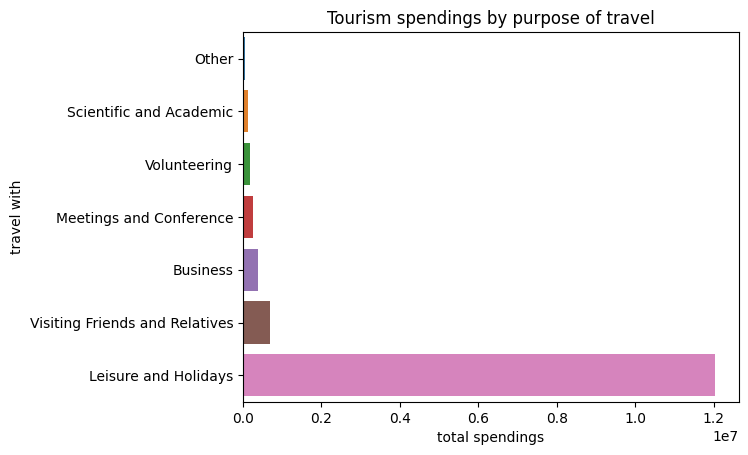

In [272]:
df_activity = df_train.groupby(['purpose'])['total_cost_euro'].sum().rename("travel_cost_by_purpose").sort_values()
df_activity= df_activity.to_frame().reset_index()

sns.barplot(y='purpose', x='travel_cost_by_purpose', data=df_activity)

plt.xlabel("total spendings")
plt.ylabel("travel with")
plt.title("Tourism spendings by purpose of travel")
plt.show()

## Tour Arrangement 

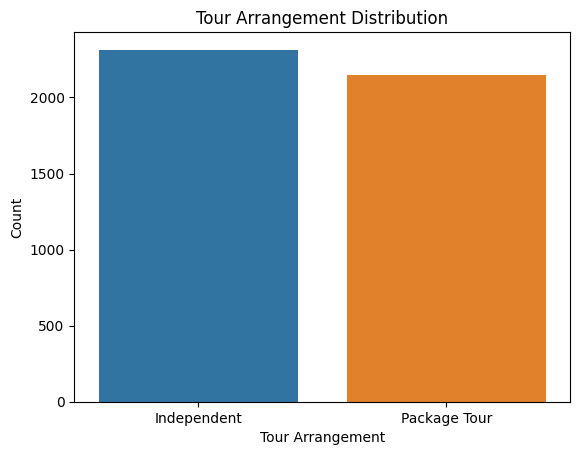

In [211]:
#fig,ax = plt.subplots(1,2,figsize=(16,16))

sns.countplot(x='tour_arrangement', data=df_train)
plt.title('Tour Arrangement Distribution')
plt.xlabel('Tour Arrangement')
plt.ylabel('Count')
plt.show()

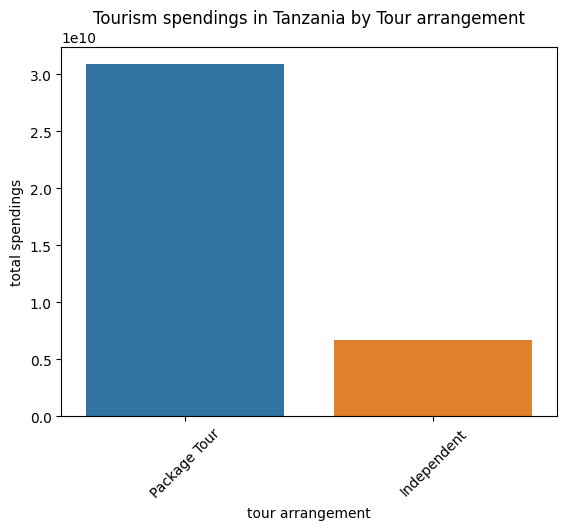

In [264]:
df_country_arrangment = df_train.groupby(['tour_arrangement'])['total_cost'].sum().rename("total_cost_by_country").sort_values(ascending=False)
df_country_arrangment= df_country_arrangment.to_frame().reset_index()

sns.barplot(x='tour_arrangement', y='total_cost_by_country', data=df_country_arrangment)

plt.xticks(rotation=45)
plt.ylabel("total spendings")
plt.xlabel("tour arrangement")
plt.title("Tourism spendings in Tanzania by Tour arrangement")
plt.show()

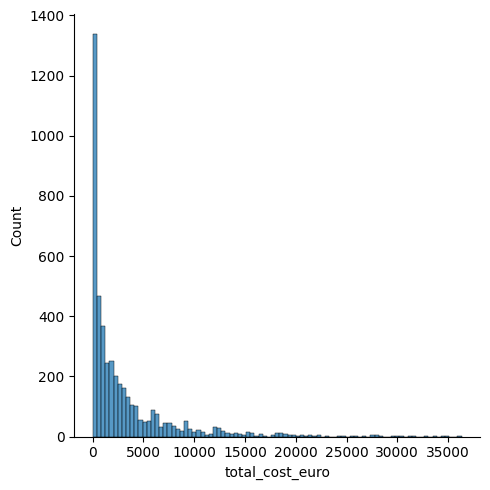

In [266]:
sns.displot(df_train, x="total_cost_euro")

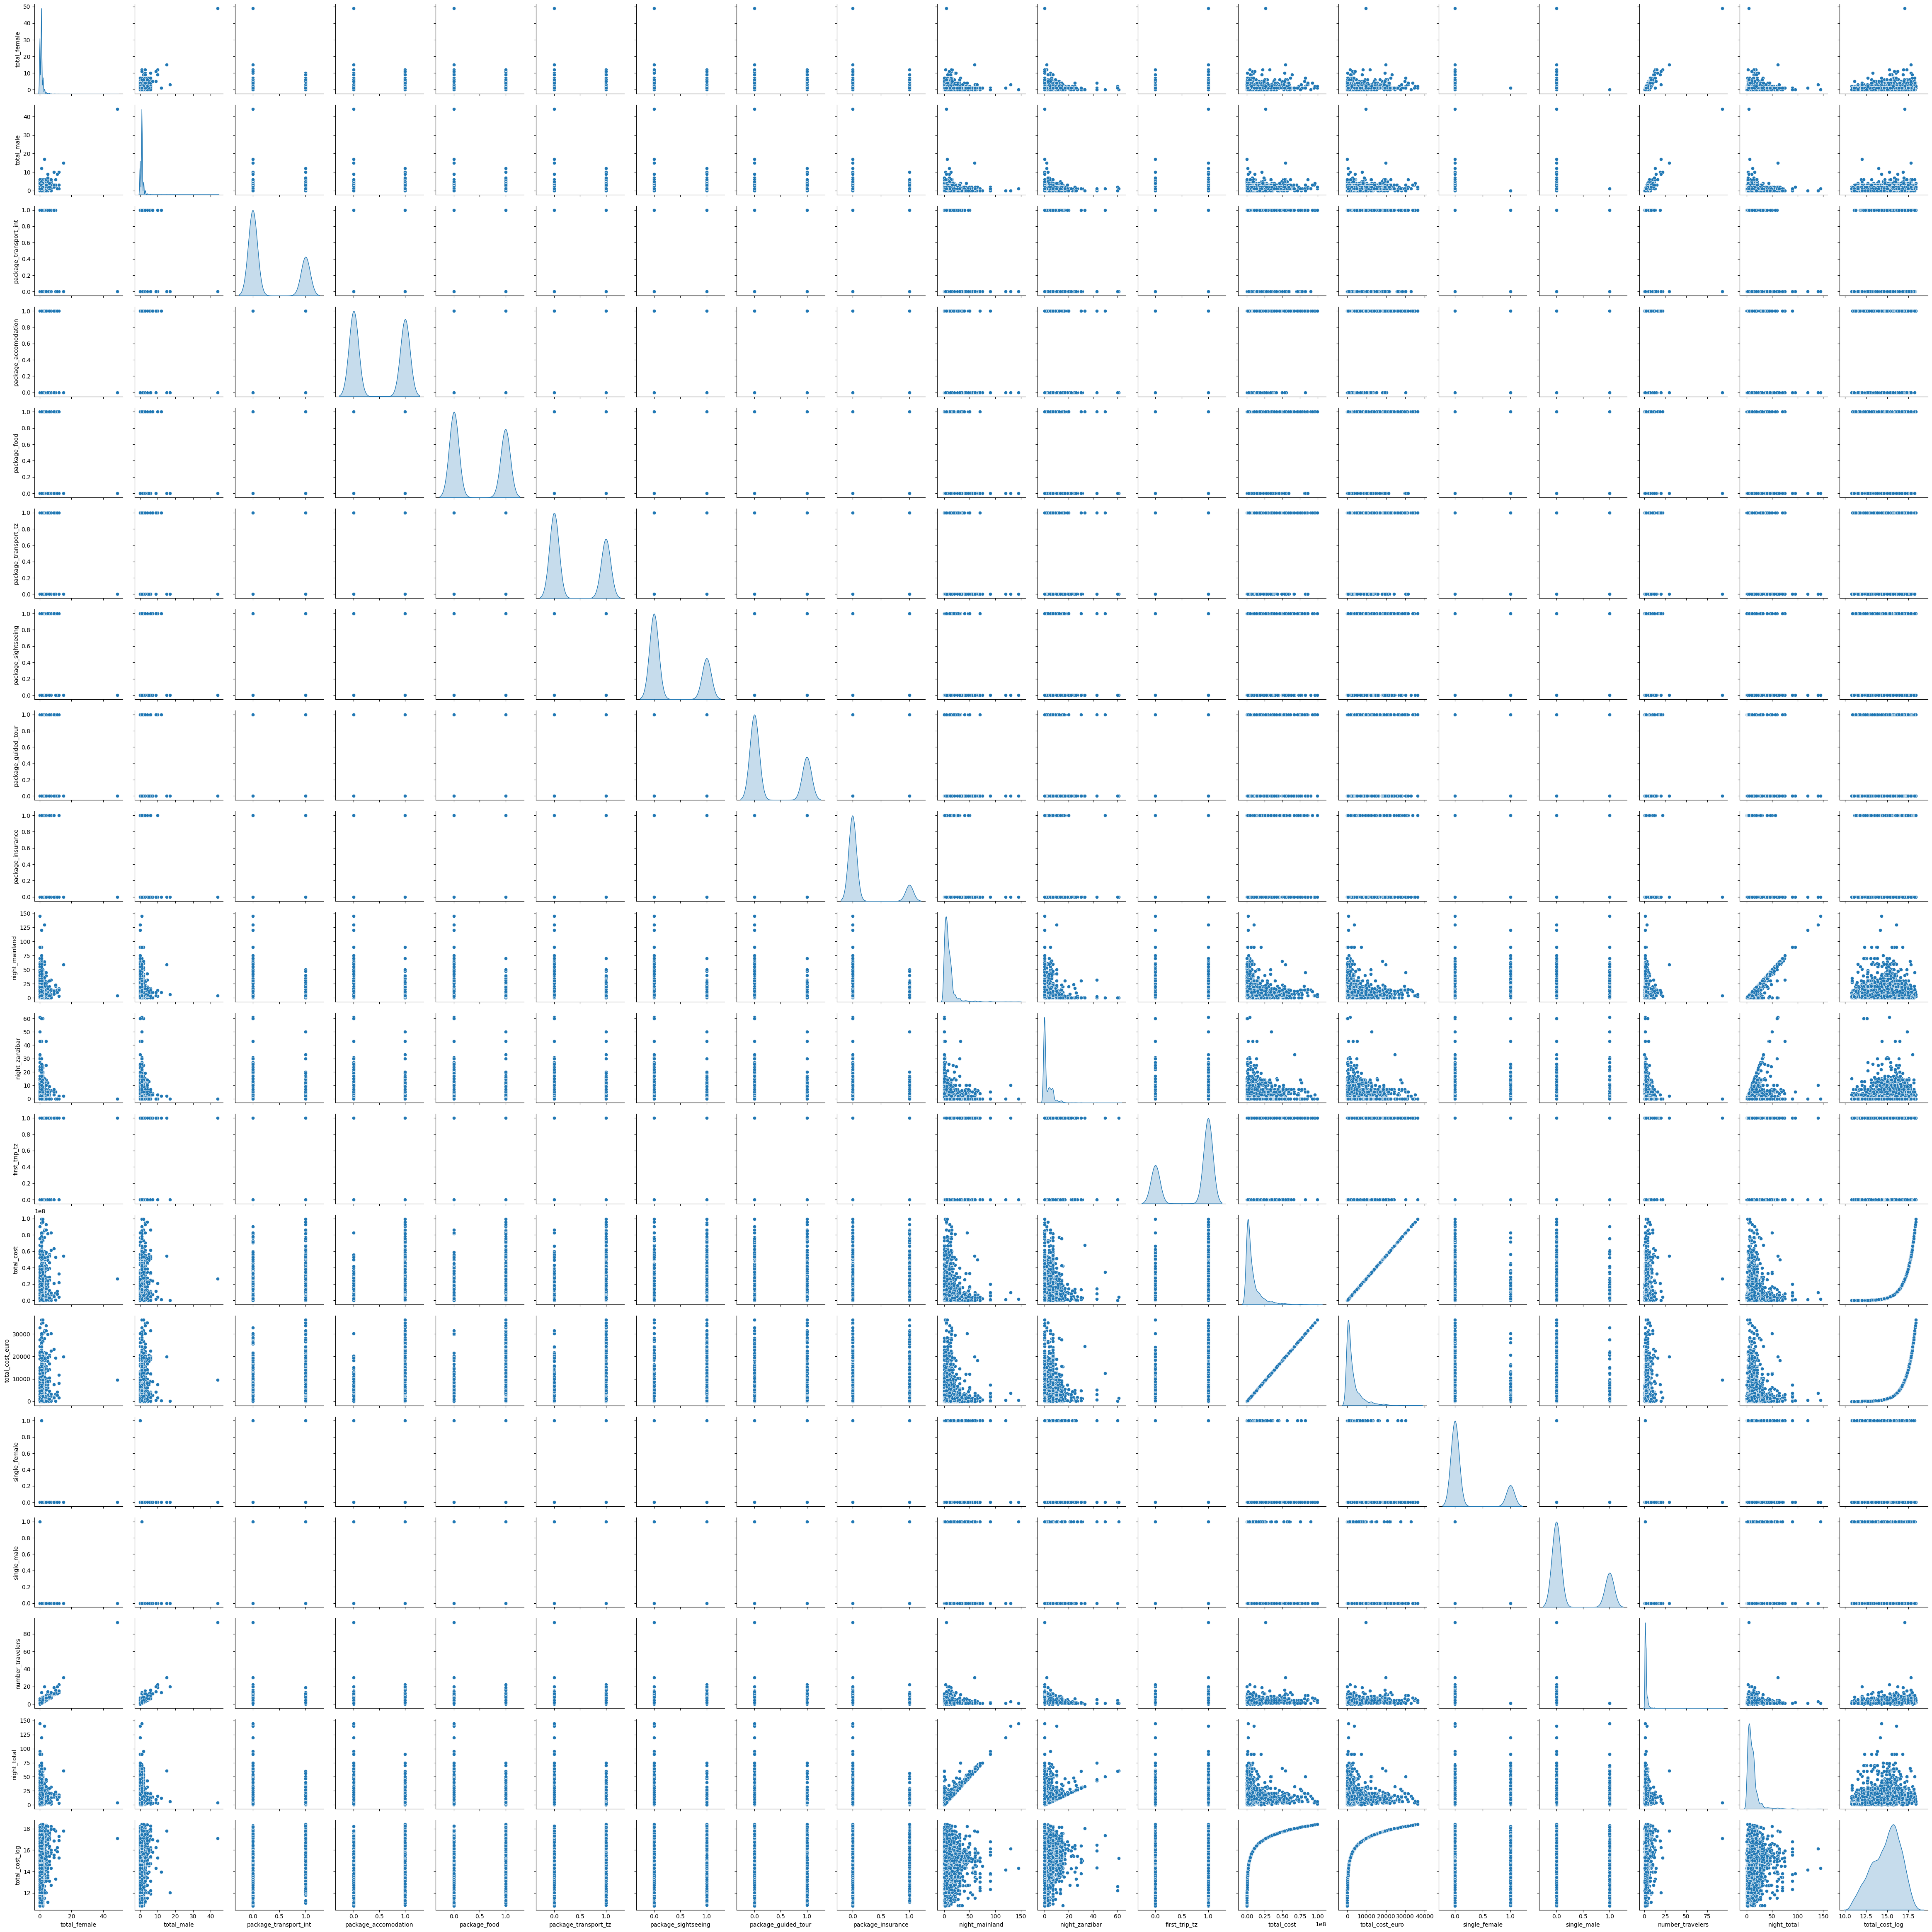

In [190]:

sns.pairplot(df_train, diag_kind='kde')
plt.show()